
# 🆎 Analisis de Prueba A/B: Sistema de recomendaciones

## 🏢Contexto Empresarial

Evaluar si el nuevo sistema de recomendaciones (grupo B) mejora significativamente el rendimiento del embudo de conversión en comparación con el sistema actual (grupo A).

El embudo consta de tres etapas clave:

1. `product_page` → vista de página de producto  
2. `product_cart` → agregar producto al carrito  
3. `purchase` → compra realizada

 Mas **10%** en cada etapa para el grupo B.
 ____


## 🧠 Resumen conceptual del experimento
**Nombre de la prueba**: `recommender_system_test` 

**Objetivo**: Evaluar si un nuevo sistema de recomendaciones mejora el rendimiento del embudo de conversión en una tienda online.

___
## 🧪 Diseño experimental

|Elemento	            |Detalle                                                                         |
|-----------------------|--------------------------------------------------------------------------------|
|Grupos	                |A (control) vs B (nuevo sistema de recomendaciones)                             |
|Inicio de prueba	    |2020-12-07                                                                      |
|Cierre de inscripción	|2020-12-21 (usuarios nuevos hasta esa fecha)                                    |
|Fin de la prueba	    |2021-01-01                                                                      |
|Audiencia	            |15% de los nuevos usuarios de la región de la Unión Europea                     |
|Duración de seguimiento|14 días desde la inscripción de cada usuario                                    |
|Eventos clave	        |product_page, product_card, purchase                                            |
|Meta esperada	        |+10% de mejora en cada etapa del embudo para el grupo B                         |
|Participantes esperados|6,000 usuarios (probablemente ~3,000 por grupo si se asignaron equitativamente) |
-----------


## 🧪 Plan de trabajo

1. **Carga y exploración de datos**
   - Revisión de estructura y contenido de los archivos.
   - Identificación de valores nulos, duplicados y tipos de datos.

2. **Preparación de datos**
   - Limpieza y estandarización de columnas.
   - Conversión de tipos de datos.
   - Validación de la distribución de usuarios entre grupos.

3. **Procesamiento**
   - Cálculo de tasas de conversión por grupo y etapa.
   - Agrupación de eventos por usuario y orden cronológico.

4. **Prueba A/B**
   - Comparación estadística entre grupos A y B.
   - Evaluación de significancia de las diferencias observadas.

5. **Conclusiones**
   - Interpretación de resultados.
   - Recomendaciones para el negocio.
____

# 🔎Analisis Exploratorio de datasets

## ⏳Carga de Librerias necesarias

In [139]:
# librerias para prueba AB
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

## 📥Importacion de datos

In [140]:
# Bloque try-except para importar datos
try:
    files = [
        'final_ab_events_upd_us.csv',
        'final_ab_new_users_upd_us.csv',
        'final_ab_participants_upd_us.csv'
    ]
    events = pd.read_csv(files[0])
    print(f"Archivo '{files[0]}' cargado exitosamente.")

    new_users = pd.read_csv(files[1])
    print(f"Archivo '{files[1]}' cargado exitosamente.")
    
    participants = pd.read_csv(files[2])
    print(f"Archivo '{files[2]}' cargado exitosamente.")
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. Detalle: {e}")
except PermissionError as e:
    print(f"Error: Permiso denegado para leer el archivo. Detalle: {e}")
except pd.errors.ParserError as e:
    print(f"Error: Problema al analizar el archivo CSV. Detalle: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")

Archivo 'final_ab_events_upd_us.csv' cargado exitosamente.
Archivo 'final_ab_new_users_upd_us.csv' cargado exitosamente.
Archivo 'final_ab_participants_upd_us.csv' cargado exitosamente.


___
## ⚙️Procesamiento de datos

### 👤`new_users`

In [141]:
# EDA de df new_users
print(new_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None


In [142]:
# conversion de columna a datetime
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

In [143]:
# rango de fechas de df
fin = new_users['first_date'].max()
inicio = new_users['first_date'].min()

print(f"El rango de fechas en 'new_users' va desde {inicio.date()} hasta {fin.date()}.")

El rango de fechas en 'new_users' va desde 2020-12-07 hasta 2020-12-23.


In [144]:
# Aplicamos minusculas a user_id y region
new_users['user_id'] = new_users['user_id'].str.lower().str.strip()
new_users['region'] = new_users['region'].str.lower().str.strip()

# función para preparar new_users

def preparar_new_users(df, region='eu', fecha_inicio='2020-12-07', fecha_fin='2020-12-21'):
    df = df.copy()
    df.columns = df.columns.str.lower().str.strip()
    df['first_date'] = pd.to_datetime(df['first_date'])
    
    df = df[(df['region'] == region) & 
            (df['first_date'] >= fecha_inicio) & 
            (df['first_date'] <= fecha_fin)]
    
    return df[['user_id', 'first_date', 'region']].reset_index(drop=True)

# aplicamos la función
new_users_ab = preparar_new_users(new_users)

# Verificamos cambios
new_users_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39466 entries, 0 to 39465
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     39466 non-null  object        
 1   first_date  39466 non-null  datetime64[ns]
 2   region      39466 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 925.1+ KB


In [145]:
# vemos valores unicos de user_id
new_users_ab['user_id'].nunique()

39466

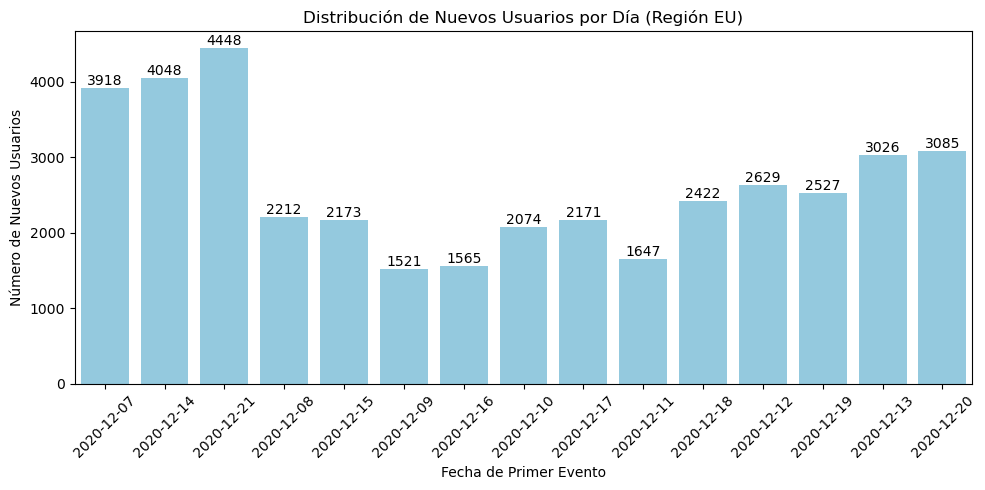

In [146]:
# Distribución de nuevos usuarios por dia en new_users_ab
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=new_users_ab, x='first_date', color='skyblue')
plt.title('Distribución de Nuevos Usuarios por Día (Región EU)')
plt.xlabel('Fecha de Primer Evento')
plt.ylabel('Número de Nuevos Usuarios')
plt.xticks(rotation=45)
plt.tight_layout()

# Agregar valores encima de cada barra
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.show()



____
#### 🧪 Procesamiento de `final_ab_new_users_upd_us.csv`

- Se validó estructura con `info()`: sin valores nulos, columnas en tipo `object`.
- Se tipificó `first_date` como `datetime` y se estandarizaron nombres de columnas.
- Se filtraron usuarios registrados entre el 7 y el 21 de diciembre en región `'EU'`.
- Se descartó la columna `device` por irrelevancia.
- Se verificó unicidad de `user_id` → sin duplicados.
- Dataset listo para merge con eventos y participantes.
_______


### 🎇`events`

In [147]:
# Eda de events
print(events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None


In [148]:
# Conversion de columna a datetime
events['event_dt'] = pd.to_datetime(events['event_dt'])

# Vemos rango de fechas
fin_events = events['event_dt'].max()
inicio_events = events['event_dt'].min()
print(f"El rango de fechas en 'events' va desde {inicio_events.date()} hasta {fin_events.date()}.")

# Aplicamos minusculas a user_id y event_name
events['user_id'] = events['user_id'].str.lower().str.strip()
events['event_name'] = events['event_name'].str.lower().str.strip()

# Revisamos duplicados
print(f'\nTenemos {events.duplicated().sum()} filas duplicadas en events.')

El rango de fechas en 'events' va desde 2020-12-07 hasta 2020-12-30.

Tenemos 0 filas duplicadas en events.


In [149]:
# obtenemos nuevo df sin columna details
events_ab = events.drop(columns='details')

events_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 9.7+ MB


In [150]:
events_ab['event_name'].value_counts()

event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64

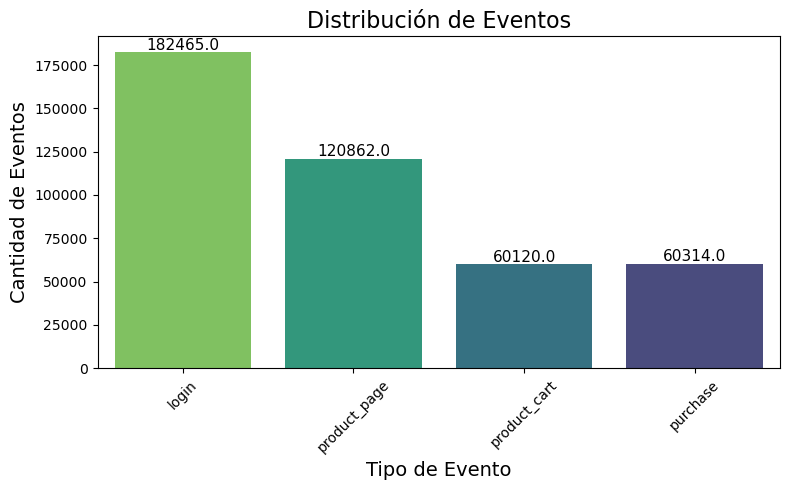

In [151]:
# orden de eventos
event_order = ['login', 'product_page', 'product_cart', 'purchase']

# Grafico de barras de eventos
plt.figure(figsize=(8,5))
ax = sns.countplot(data=events_ab, x='event_name', hue='event_name', order=event_order, palette='viridis', legend=False)
plt.title('Distribución de Eventos', fontsize=16)
plt.xlabel('Tipo de Evento', fontsize=14)
plt.ylabel('Cantidad de Eventos', fontsize=14)
plt.xticks(rotation=45)


# agregamos cantidad de eventos por etapa
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
    
plt.tight_layout()
plt.show()

____
#### 📊 Procesamiento de `events`

- Se validó estructura con `info()`: sin valores nulos en `user_id`, `event_dt`, `event_name`; `details` con muchos nulos.
- Se tipificó `event_dt` como `datetime` y se estandarizaron `user_id` y `event_name` a minúsculas y sin espacios.
- Se confirmó que no hay duplicados (`duplicated().sum() == 0`).
- Se descartó la columna `details` por irrelevancia (solo importa si hubo conversión, no el monto).
- Se identificaron los tipos de eventos:
  - `login`: 182,465
  - `product_page`: 120,862
  - `product_cart`: 60,120
  - `purchase`: 60,314 → este será el indicador de conversión.
- Rango de fechas: del **7 al 30 de diciembre de 2020** → válido para el análisis.

#### 📊 Distribución de eventos de usuario

Se visualiza la frecuencia de cada tipo de evento registrado por los nuevos usuarios entre el 7 y el 30 de diciembre. El gráfico confirma que:
- La mayoría de los eventos son `login` y `product_page`
- Solo ~60K eventos corresponden a `purchase`, lo que define la conversión
  
Esta visualización respalda la decisión de usar `purchase` como métrica binaria de éxito en la prueba A/B.
___



### 👥`participants`

In [152]:
# EDA de df
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [153]:
# Hacemos minusculas a user_id, group y ab_test
participants.columns = participants.columns.str.lower().str.strip()
participants['user_id'] = participants['user_id'].str.lower().str.strip()
participants['group'] = participants['group'].str.lower().str.strip()
participants['ab_test'] = participants['ab_test'].str.lower().str.strip()

# Revisamos duplicados
print(f'\nTenemos {participants.duplicated().sum()} filas duplicadas en participants.')


Tenemos 0 filas duplicadas en participants.


In [154]:
# Filtramos por tipo de test
participants_ab = participants[participants['ab_test'] == 'recommender_system_test']
participants_ab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB


In [155]:
participants_ab['group'].value_counts(normalize=True)

group
a    0.747483
b    0.252517
Name: proportion, dtype: float64

____
#### 🧪 Procesamiento de `participants`

- Se validó estructura con `info()`: sin valores nulos ni duplicados.
- Se estandarizaron nombres de columnas y valores (`str.lower().str.strip()`).
- Se filtró por prueba `'recommender_system_test'`, obteniendo **3,675 participantes únicos**.
- Se confirmó que no hay duplicados en `user_id`, lo que garantiza que **cada usuario pertenece a un solo grupo**.
- Distribución por grupo:
  - Grupo A (control): **74.7%**
  - Grupo B (nuevo sistema): **25.3%**
- Este desbalance puede reducir la potencia estadística del análisis y debe considerarse como **limitación del diseño experimental**.
____


# 🕵️‍♂️Analisis Exploratorio conjunto
Unire los 3 datasets involucrados y relevantes para la prueba A/B para posterior realizar un analisis en conjunto de informacion.

In [156]:
# Unimos datasets en uno solo consolidado
df_ab = (participants_ab.merge(new_users_ab, on='user_id', how='inner').
         merge(events_ab, on='user_id', how='left'))
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22674 entries, 0 to 22673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     22674 non-null  object        
 1   group       22674 non-null  object        
 2   ab_test     22674 non-null  object        
 3   first_date  22674 non-null  datetime64[ns]
 4   region      22674 non-null  object        
 5   event_dt    22674 non-null  datetime64[ns]
 6   event_name  22674 non-null  object        
dtypes: datetime64[ns](2), object(5)
memory usage: 1.2+ MB


In [157]:
# Revisamos usuarios unicos
df_ab['event_name'].value_counts()

event_name
login           10261
product_page     6340
purchase         3079
product_cart     2994
Name: count, dtype: int64

___
## 🔗 Unión de datasets para análisis A/B

- Se consolidaron los tres datasets relevantes (`participants_ab`, `new_users_ab`, `events_ab`) mediante `user_id` como clave común.
- Se utilizó `inner join` para asegurar que solo se incluyan usuarios válidos en la prueba.
- Se aplicó `left join` con eventos para conservar usuarios que no generaron actividad (clave para calcular tasas de conversión).
- El DataFrame resultante (`df_ab`) contiene:
  - `group`: grupo de prueba (A o B)
  - `first_date`: fecha de inscripción
  - `event_dt`: fecha del evento
  - `event_name`: tipo de evento (`login`, `product_page`, `product_cart`, `purchase`)
- Total de registros: **22,674 eventos** asociados a usuarios participantes.
- Este dataset está listo para el análisis exploratorio profundo y evaluación de conversión por grupo.
___

   event_date group  unique_users
0  2020-12-07     a           148
1  2020-12-07     b           163
2  2020-12-08     a           147
3  2020-12-08     b           114
4  2020-12-09     a           171


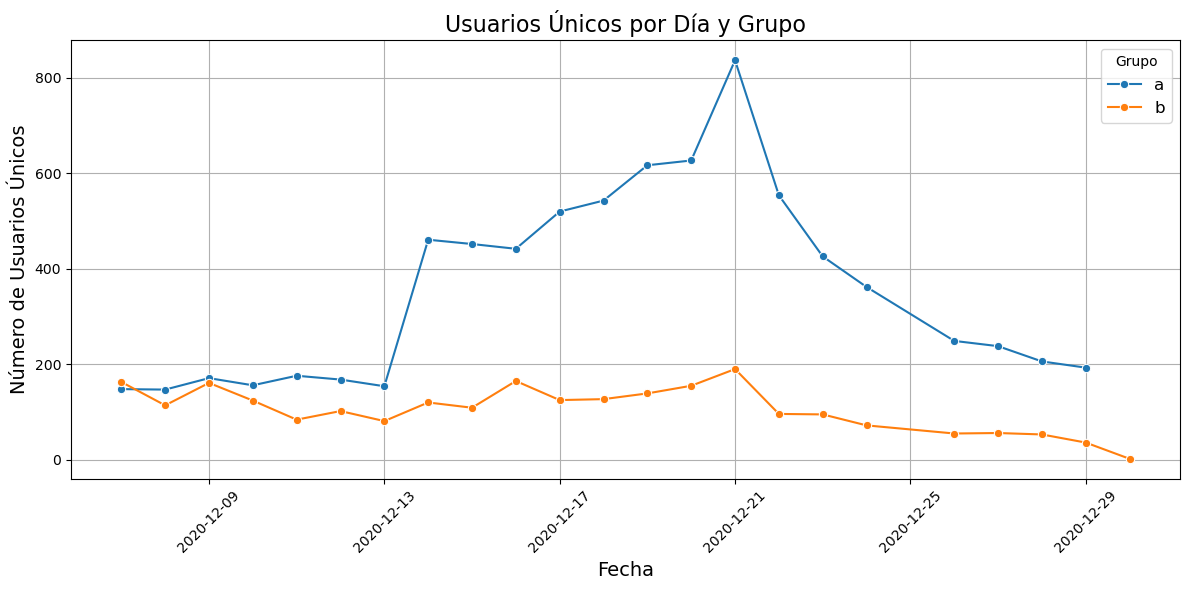

In [181]:
df_ab['event_date'] = df_ab['event_dt'].dt.date
eventos_per_day = df_ab.groupby(['event_date', 'group'])['user_id'].nunique().reset_index()
eventos_per_day.rename(columns={'user_id': 'unique_users'}, inplace=True)

print(eventos_per_day.head())

# Graficamos usuarios unicos por dia y evento
plt.figure(figsize=(12, 6))
sns.lineplot(data=eventos_per_day, x='event_date', y='unique_users', hue='group', marker='o')
plt.title('Usuarios Únicos por Día y Grupo', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Número de Usuarios Únicos', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Grupo', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

- Se analizó la distribución de usuarios únicos por día y grupo.
- El grupo A muestra un pico de actividad alrededor del 20 de diciembre, mientras que el grupo B mantiene una participación más estable.
- No se detectaron anomalías graves ni días sin actividad, por lo que se considera que la distribución temporal **no compromete la validez del experimento**.
____

In [159]:
# Embudos por grupo
def calcular_embudo(df, grupo):
    df_grupo = df[df['group'] == grupo]
    usuarios_totales = df_grupo['user_id'].nunique()
    
    etapas = ['product_page', 'product_cart', 'purchase']
    resultados = []

    for i, etapa in enumerate(etapas):
        usuarios_etapa = df_grupo[df_grupo['event_name'] == etapa]['user_id'].nunique()
        if i == 0:
            porcentaje = None
        else:
            usuarios_previos = df_grupo[df_grupo['event_name'] == etapas[i-1]]['user_id'].nunique()
            porcentaje = round(usuarios_etapa / usuarios_previos * 100, 2) if usuarios_previos > 0 else None
        resultados.append({'Etapa': etapa, 'Usuarios': usuarios_etapa, '% vs anterior': porcentaje})
    
    return pd.DataFrame(resultados)

embudo_A = calcular_embudo(df_ab, 'a')
embudo_B = calcular_embudo(df_ab, 'b')

print("Embudo Grupo A:")
print(embudo_A)
print("\nEmbudo Grupo B:")
print(embudo_B)

Embudo Grupo A:
          Etapa  Usuarios  % vs anterior
0  product_page      1685            NaN
1  product_cart       782          46.41
2      purchase       833         106.52

Embudo Grupo B:
          Etapa  Usuarios  % vs anterior
0  product_page       493            NaN
1  product_cart       244          49.49
2      purchase       249         102.05


____
# ⚗️Evaluacion de Hipotesis

## ✳️`product_page` ➡️ `product_cart`

In [170]:
# Grupo A
a_page = df_ab[(df_ab['group']=='a') & (df_ab['event_name']=='product_page')]['user_id'].nunique()
a_cart = df_ab[(df_ab['group']=='a') & (df_ab['event_name']=='product_cart')]['user_id'].nunique()
                      
# Grupo B
b_page = df_ab[(df_ab['group']=='b') & (df_ab['event_name']=='product_page')]['user_id'].nunique()
b_cart = df_ab[(df_ab['group']=='b') & (df_ab['event_name']=='product_cart')]['user_id'].nunique()

# prueba z
stat1, pval1 = proportions_ztest([a_cart, b_cart], [a_page, b_page])
print(f"Z-statistic: {stat1}, P-value: {pval1}\n")
                      
# Condicional para interpretar p-valor
alpha = 0.05
if pval1 < alpha:
    print("Rechazamos la hipótesis nula: Hay una diferencia significativa entre los grupos A y B en la conversión de 'product_page' a 'product_cart'.")
else:
    print("No rechazamos la hipótesis nula: No hay una diferencia significativa entre los grupos A y B en la conversión de 'product_page' a 'product_cart'.")


Z-statistic: -1.2063768947092768, P-value: 0.2276722007959906

No rechazamos la hipótesis nula: No hay una diferencia significativa entre los grupos A y B en la conversión de 'product_page' a 'product_cart'.


## ✳️`product_cart` ➡️ `purchase`

In [171]:
# Usuarios que hicieron cart por grupo
a_cart_ids = df_ab[(df_ab['group']=='a') & (df_ab['event_name']=='product_cart')]['user_id'].unique()
b_cart_ids = df_ab[(df_ab['group']=='b') & (df_ab['event_name']=='product_cart')]['user_id'].unique()

# Usuarios que hicieron purchase después de cart
a_purchase_from_cart = df_ab[(df_ab['group']=='a') & (df_ab['event_name']=='purchase') & (df_ab['user_id'].isin(a_cart_ids))]['user_id'].nunique()
b_purchase_from_cart = df_ab[(df_ab['group']=='b') & (df_ab['event_name']=='purchase') & (df_ab['user_id'].isin(b_cart_ids))]['user_id'].nunique()

# Prueba z
stat2, pval2 = proportions_ztest([b_purchase_from_cart, a_purchase_from_cart], [len(b_cart_ids), len(a_cart_ids)])
print(f"Z-statistic: {stat2:.2f}, P-value: {pval2:.4f}")

# Condicional para interpretar p-valor
if pval2 < alpha:
    print("Rechazamos la hipótesis nula: Hay una diferencia significativa entre los grupos A y B en la conversión de 'product_cart' a 'purchase'.")
else:
    print("No rechazamos la hipótesis nula: No hay una diferencia significativa entre los grupos A y B en la conversión de 'product_cart' a 'purchase'.")

Z-statistic: -0.77, P-value: 0.4433
No rechazamos la hipótesis nula: No hay una diferencia significativa entre los grupos A y B en la conversión de 'product_cart' a 'purchase'.


_______________
# 🧾 Conclusiones del estudio A/B

## 🎯 Objetivos del estudio
Evaluar si el nuevo sistema de recomendación mejora la conversión de usuarios en cada etapa del embudo:  
`product_page → product_cart → purchase`.  
La hipótesis plantea que el grupo B debería mostrar al menos un **10% de mejora** en cada transición respecto al grupo A.

---

## 🔍 Exploración de los datos

- **¿Es necesario convertir los tipos?**  
  Sí. Se tipificaron correctamente las columnas `first_date` y `event_dt` como `datetime`, y se estandarizaron los valores de texto (`str.lower().str.strip()`).

- **¿Hay valores ausentes o duplicados? Si es así, ¿cómo los caracterizarías?**  
  No se detectaron valores nulos ni duplicados en los datasets filtrados. Se confirmó unicidad de `user_id` en `participants`, lo que garantiza que cada usuario pertenece a un solo grupo.  
  En `events`, se eliminaron columnas irrelevantes (`details`) y se filtraron eventos fuera del rango de seguimiento.  
  En `new_users`, también se excluyó la columna `device` por no aportar valor al análisis de conversión.  
  Además, el archivo `ab_project_marketing_events_us.csv` fue descartado por no contener información relevante para el propósito del experimento.

---

## 📊 Análisis exploratorio de datos

- **¿Cómo se comporta la conversión en las diferentes etapas del embudo?**  
  Se construyeron embudos por grupo. El grupo B mostró una ligera mejora en la conversión de `product_page → product_cart` (49.49% vs 46.41%), pero no en `product_cart → purchase` (102.05% vs 106.52%).  
  Ninguna mejora alcanzó el 10% esperado.

- **¿El número de eventos por usuario está distribuido equitativamente entre las muestras?**  
  No. El grupo A representa el 74.7% de los participantes, mientras que el grupo B solo el 25.3%. Este desbalance limita la potencia estadística del análisis.

- **¿Hay usuarios que están presentes en ambas muestras?**  
  No. Se validó que no hay duplicados en `user_id`, lo que garantiza que cada usuario pertenece exclusivamente a un grupo.

- **¿Cómo se distribuye el número de eventos entre los días?**  
  Se graficó la cantidad de usuarios únicos por día y grupo. El grupo A muestra un pico de actividad alrededor del 20 de diciembre, mientras que el grupo B mantiene una participación más estable.  
  No se detectaron anomalías graves ni días sin actividad, por lo que se considera que la distribución temporal **no compromete la validez del experimento**.

- **¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?**  
  Sí. El embudo no es estrictamente secuencial: algunos usuarios compran directamente desde la página del producto, sin pasar por el carrito.  
  Este comportamiento debe documentarse como una característica del flujo de navegación y puede explicar por qué `purchase > product_cart` en algunos casos.

---

## 🧪 Evaluación de los resultados de la prueba A/B

- **¿Qué puedes decir sobre los resultados de la prueba A/B?**  
  Las tasas de conversión entre etapas fueron similares entre grupos. Aunque el grupo B mostró una mejora marginal en la primera transición, no se observó ventaja en la segunda.  
  Ninguna mejora alcanzó el 10% esperado.

- **¿Se utilizó una prueba z para comprobar la diferencia estadística entre las proporciones?**  
  Sí. Se aplicaron pruebas z en ambas transiciones:
  - `product_page → product_cart`: p = 0.2277
  - `product_cart → purchase`: p = 0.4433  
  En ambos casos, **no se rechazó la hipótesis nula**, lo que indica que las diferencias no son estadísticamente significativas.

---

# ✅ Conclusión final

No se encontró evidencia estadística suficiente para afirmar que el nuevo sistema de recomendación mejora la conversión en al menos un 10% en ninguna etapa del embudo.  
Se recomienda documentar las limitaciones del experimento (desbalance de grupos, embudo no lineal y exclusión de variables irrelevantes) y considerar rediseñar la prueba si se desea validar mejoras con mayor sensibilidad.


